In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pyarrow.parquet as pq
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from gait_transformer import GaitTransformer
from training_utils import unscale_kinematics, unscale_gait_state, scale_gait_state
from gait_kinematics_model import GaitModel
from save_best_model import SaveBestModel
from torch_training_utils import WeightedKinematicsLoss, enum_parameters

from datasets import WindowedGaitDataset, ToTensor

import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

2023-02-07 20:48:13.592366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 20:48:13.812803: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-07 20:48:14.596838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-07 20:48:14.596962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

In [6]:
!gsutil cp -r gs://ml_gait_estimation/r01_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_ordered_corrupt_time.csv...
- [1 files][301.3 MiB/301.3 MiB]                                                
Operation completed over 1 objects/301.3 MiB.                                    


In [7]:
!gsutil cp -r gs://ml_gait_estimation/r01_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_randomized_corrupt_time.csv...
- [1 files][301.6 MiB/301.6 MiB]                                                
Operation completed over 1 objects/301.6 MiB.                                    


In [8]:
!gsutil cp -r gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv...
\ [1 files][506.4 MiB/506.4 MiB]                                                
Operation completed over 1 objects/506.4 MiB.                                    


In [9]:
!gsutil cp -r gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv...
\ [1 files][507.1 MiB/507.1 MiB]                                                
Operation completed over 1 objects/507.1 MiB.                                    


In [10]:
!gsutil cp -r gs://ml_gait_estimation/gt_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/gt_ordered_corrupt_time.csv...
/ [1 files][558.0 MiB/558.0 MiB]                                                
Operation completed over 1 objects/558.0 MiB.                                    


In [11]:
!gsutil cp -r gs://ml_gait_estimation/gt_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/gt_randomized_corrupt_time.csv...
/ [1 files][558.3 MiB/558.3 MiB]                                                
Operation completed over 1 objects/558.3 MiB.                                    


In [2]:
!gsutil cp -r gs://ml_gait_estimation/r01_ordered_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/r01_randomized_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/dataport_ordered_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/dataport_randomized_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/gt_ordered_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/gt_randomized_stairs_label_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_ordered_stairs_label_corrupt_time.csv...
- [1 files][303.9 MiB/303.9 MiB]                                                
Operation completed over 1 objects/303.9 MiB.                                    
Copying gs://ml_gait_estimation/r01_randomized_stairs_label_corrupt_time.csv...
\ [1 files][304.1 MiB/304.1 MiB]                                                
Operation completed over 1 objects/304.1 MiB.                                    
Copying gs://ml_gait_estimation/dataport_ordered_stairs_label_corrupt_time.csv...
/ [1 files][506.4 MiB/506.4 MiB]                                                
Operation completed over 1 objects/506.4 MiB.                                    
Copying gs://ml_gait_estimation/dataport_randomized_stairs_label_corrupt_time.csv...
\ [1 files][507.1 MiB/507.1 MiB]                                                
Operation completed over 1 objects/507.1 MiB.                                    
Copying gs://ml_gait_est

In [2]:
window_size = 10
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-1,1)

filename_dataport_ordered = 'dataport_ordered_stairs_label_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_stairs_label_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_stairs_label_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_stairs_label_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_stairs_label_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_stairs_label_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

DO_DECIMATION = not True
if DO_DECIMATION:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized, nrows=10000)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered, nrows=10000)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered, nrows=10000)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized, nrows=10000)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered, nrows=10000)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized, nrows=10000)

    
else:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)


# REMOVE RANDOM SUBJECTS FOR X-VALIDATION
#FROM R01, remove two: AB02 and AB06
#FROM DATAPORT, remove three: AB09, AB05, and AB10
#FROM GT, remove six, AB25, AB28, AB30, AB20, AB12, AB09
REMOVE_SUBS_XVAL = True

if REMOVE_SUBS_XVAL:
    #r01 ordered
    index_sub_remove_r01 = gait_data_r01_ordered[ (gait_data_r01_ordered['subj_id'] == 2) | (gait_data_r01_ordered['subj_id'] == 6) ].index
    gait_data_r01_ordered_val = gait_data_r01_ordered.iloc[index_sub_remove_r01]
    gait_data_r01_ordered.drop(index_sub_remove_r01 , inplace=True)
    
    #r01 randomized
    index_sub_remove_r01 = gait_data_r01_randomized[ (gait_data_r01_randomized['subj_id'] == 2) | (gait_data_r01_randomized['subj_id'] == 6) ].index
    gait_data_r01_randomized_val = gait_data_r01_randomized.iloc[index_sub_remove_r01]
    gait_data_r01_randomized.drop(index_sub_remove_r01 , inplace=True)
    
    print(gait_data_r01_ordered.head())
    print(gait_data_r01_ordered_val.head())
    
    #dataport ordered
    index_sub_remove_dataport = gait_data_dataport_ordered[ (gait_data_dataport_ordered['subj_id'] == 9) | 
                                                           (gait_data_dataport_ordered['subj_id'] == 5) |
                                                          (gait_data_dataport_ordered['subj_id'] == 10)].index

    gait_data_dataport_ordered_val = gait_data_dataport_ordered.iloc[index_sub_remove_dataport]
    gait_data_dataport_ordered.drop(index_sub_remove_dataport , inplace=True)
    
    #dataport randomized
    index_sub_remove_dataport = gait_data_dataport_randomized[ (gait_data_dataport_randomized['subj_id'] == 9) | 
                                                           (gait_data_dataport_randomized['subj_id'] == 5) |
                                                          (gait_data_dataport_randomized['subj_id'] == 10)].index

    gait_data_dataport_randomized_val = gait_data_dataport_randomized.iloc[index_sub_remove_dataport]
    gait_data_dataport_randomized.drop(index_sub_remove_dataport , inplace=True)
    
    #gt ordered
    index_sub_remove_gt = gait_data_gt_ordered[ (gait_data_gt_ordered['subj_id'] == 25) | 
                                               (gait_data_gt_ordered['subj_id'] == 28) |
                                              (gait_data_gt_ordered['subj_id'] == 30) |
                                              (gait_data_gt_ordered['subj_id'] == 20) |
                                              (gait_data_gt_ordered['subj_id'] == 12) |
                                              (gait_data_gt_ordered['subj_id'] == 9)].index
    
    gait_data_gt_ordered_val = gait_data_gt_ordered.iloc[index_sub_remove_gt]
    gait_data_gt_ordered.drop(index_sub_remove_gt , inplace=True)
    
    #gt randomized
    index_sub_remove_gt = gait_data_gt_randomized[ (gait_data_gt_randomized['subj_id'] == 25) | 
                                               (gait_data_gt_randomized['subj_id'] == 28) |
                                              (gait_data_gt_randomized['subj_id'] == 30) |
                                              (gait_data_gt_randomized['subj_id'] == 20) |
                                              (gait_data_gt_randomized['subj_id'] == 12) |
                                              (gait_data_gt_randomized['subj_id'] == 9)].index
    
    gait_data_gt_randomized_val = gait_data_gt_randomized.iloc[index_sub_remove_gt]
    gait_data_gt_randomized.drop(index_sub_remove_gt , inplace=True)
    
    #concatenate
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    
    gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
                              gait_data_dataport_ordered_val, gait_data_dataport_randomized_val,\
                              gait_data_gt_ordered_val, gait_data_gt_randomized_val])
    
    train_dataset = WindowedGaitDataset(gait_data=gait_data,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale=stair_height_scale,
                                                transform=ToTensor())
    
    val_dataset = WindowedGaitDataset(gait_data=gait_data_val,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale=stair_height_scale,
                                                transform=ToTensor())
    
    print('{:>5,} training samples'.format(len(train_dataset)))
    print('{:>5,} validation samples'.format(len(val_dataset)))


else:
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    # gait_data = gait_data_r01_randomized
    # gait_data = pd.concat([gait_data_r01_randomized, gait_data_dataport_randomized])
    
    dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale=stair_height_scale,
                                            transform=ToTensor())  
    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size


    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

print(val_dataset[0]['meas'][-1,:])
print(val_dataset[1]['meas'][-1,:])
print(val_dataset[2]['meas'][-1,:])

print(val_dataset[2]['state'][-1,:])






   foot_angle  foot_vel_angle  shank_angle  shank_vel_angle  heel_acc_forward  \
0    9.713109     -122.000000     6.810365       -54.155000          0.000000   
1    7.928249     -133.739183     5.993880       -61.785706         -3.391320   
2    7.120444     -147.077747     5.606053       -70.516308         -7.078094   
3    5.217823     -162.450106     4.621966       -84.205665         -3.548601   
4    3.440199     -167.100286     3.626258       -93.718654         -1.555049   

   heel_acc_upward     phase  speed  incline  stair_height  is_moving  \
0         0.000000  0.000968    0.8    -10.0           0.0        1.0   
1         2.057084  0.013282    0.8    -10.0           0.0        1.0   
2         4.304541  0.018221    0.8    -10.0           0.0        1.0   
3         2.657375  0.028783    0.8    -10.0           0.0        1.0   
4         1.422208  0.038366    0.8    -10.0           0.0        1.0   

   stride_count  HSDetected  subj_id        dt      time  
0             1

In [3]:
#SET BATCH SIZE
BATCH_SIZE_TRAIN = 512
BATCH_SIZE_VALIDATE = 2048
NUM_WORKERS = 8
# NUM_WORKERS = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle=True,
            batch_size = BATCH_SIZE_TRAIN, # Trains with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
#try shuffle off see if it fixes
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            shuffle=True,
            batch_size = BATCH_SIZE_VALIDATE, # Evaluate with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )

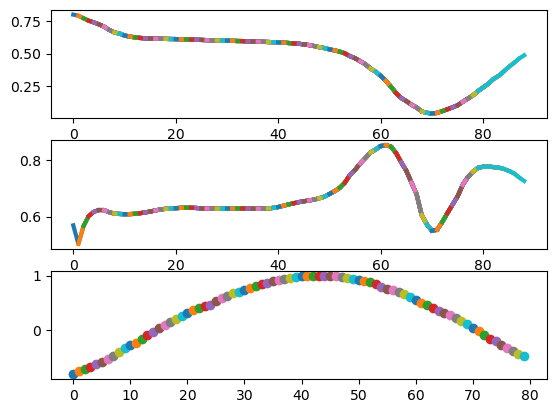

In [4]:
fig, axs = plt.subplots(3,1)

for i in range(0,80):
  y = train_dataset[i+window_size]['meas'][:,0]
  y1 = train_dataset[i+window_size]['meas'][:,4]
  x = np.array([j for j in range(len(y))])
  x = x + i

  yy = train_dataset[i+window_size]['state'][:,0]
  axs[0].plot(x,y,linewidth=3)
  axs[1].plot(x,y1,linewidth=3)
  axs[2].plot(i,yy,'o',linewidth=3)

In [6]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

model_nickname = 'gait-model-three-stairs'
# model_nickname = 'TEST'

output_dir = f'../staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    output_dir = f'../staging_area/{model_nickname}/model_save_xval/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

checkpoint_dir = 'checkpoints/'
if not os.path.exists(output_dir+checkpoint_dir):
    os.makedirs(output_dir+checkpoint_dir)




Saving model to ../staging_area/gait-model-three-stairs/model_save_xval/


In [ ]:
# SET UP GAIT MODEL
dim_val = 64 # 
n_hidden_layers=4
input_size = 5 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 6 # The number of output variables. 
# )

model = GaitModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)

    
enum_parameters(model)

best_model_name = 'best_gait_model.tar'
save_best_model = SaveBestModel(output_dir+best_model_name)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.998), eps=1e-9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, threshold=0.01, verbose=True,min_lr=1e-6)

start_epoch = 0
FROM_CHECKPOINT = not True
if FROM_CHECKPOINT:
    
    checkpoint = torch.load(output_dir+'best_gait_model.tar')
    g = checkpoint['model_state_dict']
    loss = checkpoint['loss']
    print(f'Lowest Loss: {loss}')
    save_best_model = SaveBestModel(output_dir+best_model_name, loss)
    # print(g.keys())
    model.load_state_dict(g)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f'From epoch: {start_epoch}')



epochs = 10
SAVE_EVERY_EPOCH_N = 1
first_batch = next(iter(train_dataloader))


    
#define loss function
lossfcn = WeightedKinematicsLoss(w_stairs=5)

#Extract index for time steps
DT_IDX = 6

training_RMSEs = []
validation_RMSEs = []

import time
import datetime

# Measure the total training time for the whole run.
total_t0 = time.time()

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



for epoch_i in range(start_epoch, start_epoch+epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, start_epoch+epochs))
    print('Training...')
    
    # lr = scheduler.get_lr()
    lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate: {lr}')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()
    step_ct = 0
    for step, batch in enumerate(train_dataloader):
        step_ct += 1
        # for step, batch in enumerate([first_batch] * 200):

        
        optimizer.zero_grad()   
        
        b_kinematics = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        # print(b_state)
        # input()
    
        #Run the kinematics model
        #extract only the last (most recent temporally) element of the kinematics
        #also don't estimate time
        b_kinematics = b_kinematics[:,-1,:-1].unsqueeze(dim=1)
        # print(b_kinematics.shape)

        predicted_kinematics = model(b_state)
        
        loss = lossfcn(predicted_kinematics, b_kinematics,b_state)
        # print(loss)

        loss.backward()

        optimizer.step()

        loss_value = loss.item()

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            print(loss_value)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss_value
        
    # Update the learning rate.
    #if StepLR
    # scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step_ct           
    training_RMSEs.append(avg_train_loss)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Save to checkpoints
    if (epoch_i + 1) % SAVE_EVERY_EPOCH_N == 0:
        print('Saving model checkpoint')
        model_name = f"gait_model_checkpoint_{epoch_i + 1}.tar"
        path_name = output_dir+checkpoint_dir+model_name
        print(path_name)
        torch.save({
                    'epoch':epoch_i + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, path_name)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    
    step_ct = 0
    for batch in validation_dataloader:
    #for batch in train_dataloader:
    # for step, batch in enumerate([first_batch] * 10):
        step_ct += 1

        b_kinematics = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            
            #Run the gait model model
            #extract only the last (most recent temporally) element of the kinematics
            #also don't predict time step
            b_kinematics = b_kinematics[:,-1,:-1].unsqueeze(dim=1)
            
            outputs = model(b_state)

        loss = lossfcn(outputs, b_kinematics,b_state)
        #print(loss)
        loss_value = loss.item()
        #print(loss_rmse)

        

        # Accumulate the validation loss.
        total_eval_loss += loss_value


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / step_ct
    
    #schedule PlateauLoss
    scheduler.step(avg_val_loss)
    
    validation_RMSEs.append(avg_val_loss)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    #save best model
    save_best_model(
        avg_val_loss, epoch_i+1, model, optimizer, lossfcn
    )
    
    #print training vals
    print('Training vals')
    print(validation_RMSEs)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Saving model to %s" % output_dir)

#save model params
model_name = 'gait_model_params.pt'
torch.save(model.state_dict(), output_dir+model_name)

model_name = 'gait_model_full.pt'
torch.save(model, output_dir+model_name)

#save checkpoint
model_name = f"gait_model_checkpoint_{epoch_i + 1}.tar"
torch.save({'epoch': epoch_i + 1,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': loss.item(),
                      }, path_name)

Total Trainable Params: 17414
Using GPU.

======== Epoch 1 / 10 ========
Training...
Learning Rate: 0.001
  Batch   100  of  23,359.    Elapsed: 0:00:07.
0.030232390388846397
  Batch   200  of  23,359.    Elapsed: 0:00:12.
0.045389868319034576
  Batch   300  of  23,359.    Elapsed: 0:00:17.
0.01274581253528595
  Batch   400  of  23,359.    Elapsed: 0:00:22.
0.015136770904064178
  Batch   500  of  23,359.    Elapsed: 0:00:27.
0.01310293935239315
  Batch   600  of  23,359.    Elapsed: 0:00:31.
0.01398355420678854
  Batch   700  of  23,359.    Elapsed: 0:00:36.
0.02806435525417328
  Batch   800  of  23,359.    Elapsed: 0:00:41.
0.012915446422994137
  Batch   900  of  23,359.    Elapsed: 0:00:46.
0.018633080646395683
  Batch 1,000  of  23,359.    Elapsed: 0:00:51.
0.013158278539776802
  Batch 1,100  of  23,359.    Elapsed: 0:00:56.
0.01298444252461195
  Batch 1,200  of  23,359.    Elapsed: 0:01:01.
0.01267646998167038
  Batch 1,300  of  23,359.    Elapsed: 0:01:07.
0.01229620911180973
  Ba

In [ ]:
training_RMSEs = np.array(training_RMSEs)
validation_RMSEs = np.array(validation_RMSEs)
fig, axs = plt.subplots()
axs.plot(training_RMSEs,'-',label='Train')
axs.set_ylabel('Loss (MSE)')
axs.plot(validation_RMSEs,'-',label='Val')
axs.set_xlabel('Epoch')
axs.legend()
print(np.min(validation_RMSEs))

In [13]:
#Test model

if REMOVE_SUBS_XVAL:
    test_dataset = val_dataset
else:
    # Create the DataLoader.
    filename_r01_ordered = 'r01_ordered_corrupt_time.csv'
    filename_r01_randomized = 'r01_randomized_corrupt_time.csv'
    filename_dataport_ordered = 'dataport_ordered_corrupt_time.csv'
    filename_dataport_randomized = 'dataport_randomized_corrupt_time.csv'

    wgd_small = pd.read_csv(filename_r01_randomized,skiprows=0,nrows=10000)
    # wgd_small = pd.read_csv(filename_dataport_randomized,skiprows=0,nrows=10000)
    # wgd_small = pd.read_csv(filename_r01_randomized,skiprows=0)
    window_size = 100
    meas_scale = np.array([[-69.35951035,  27.62815047],\
                            [-456.18013759,  401.13782617],\
                            [-63.71649984,  22.06632622],\
                            [-213.4786175,   396.93801619],\
                            [-35.26603985,  20.78473636],\
                            [-20.95456523,  14.63961137],\
                              [0,1]])
    
    
    speed_scale = (0,2)
    incline_scale = (-10,10)
    do_phase_trig = True



    test_dataset = WindowedGaitDataset(gait_data=wgd_small,
                                                window_size = window_size,
                                                meas_scale = meas_scale,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                transform=ToTensor())   

#test_dataset = train_dataset
BATCH_SIZE = 1024*4
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=8)
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))


# SET UP KINEMATICS MODEL
dim_val = 64 # 
n_hidden_layers=4
input_size = 5 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 6 # The number of output variables. 

best_model = GaitModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
best_model.to(device)


model_nickname = 'gait-model-three-stairs'

model_dir = f'../staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'../staging_area/{model_nickname}/model_save_xval/'

checkpoint = torch.load(model_dir+'best_gait_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_model.load_state_dict(g)

epoch = checkpoint['epoch']

# Put model in evaluation mode
best_model.eval()


# Tracking variables 
predictions , true_labels = [], []

state_vars = []

# Predict 
for batch in prediction_dataloader:

    b_kinematics = batch['meas'].to(device)
    b_state = batch['state'].to(device)
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        
        #Run the gait model
        #extract only the last (most recent temporally) element of the kinematics
        b_kinematics = b_kinematics[:,-1,:-1]
        outputs = best_model(b_state)
        # print(outputs)

    # Move logits and labels to CPU
    outputs = outputs.detach().to('cpu').numpy()
    b_kinematics = b_kinematics.to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs = np.squeeze(outputs, axis=1)
    b_state = np.squeeze(b_state, axis=1)
    
    # print(outputs.shape)
    
    #unscale
    outputs = unscale_kinematics(outputs, meas_scale)
    b_kinematics = unscale_kinematics(b_kinematics, meas_scale)
    b_state = unscale_gait_state(b_state, speed_scale, incline_scale, stair_height_scale)

    # Store predictions and true labels
    predictions.extend(outputs.tolist())
    true_labels.extend(b_kinematics.tolist())
    state_vars.extend(b_state.tolist())
print('    DONE PREDICTING')

Predicting labels for 4,477,713 test points...
Using GPU.
Lowest Loss: 0.010548620141964282


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31fc8a1c20><function _MultiProcessingDataLoaderIter.__del__ at 0x7f31fc8a1c20>
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f31fc8a1c20>Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    

self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        Traceback (most recent call last):
if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive

    DONE PREDICTING


(4477713, 6)
(4477713, 6)
Foot Angle Losses: 5.595 +- 6.085
Foot Angle Vel Losses: 47.475 +- 55.828
Shank Angle Losses: 5.406 +- 5.064
Shank Angle Vel Losses: 32.146 +- 35.927
Heel Acc Forward Losses: 3.010 +- 4.000
Heel Acc Up Losses: 2.505 +- 3.222


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


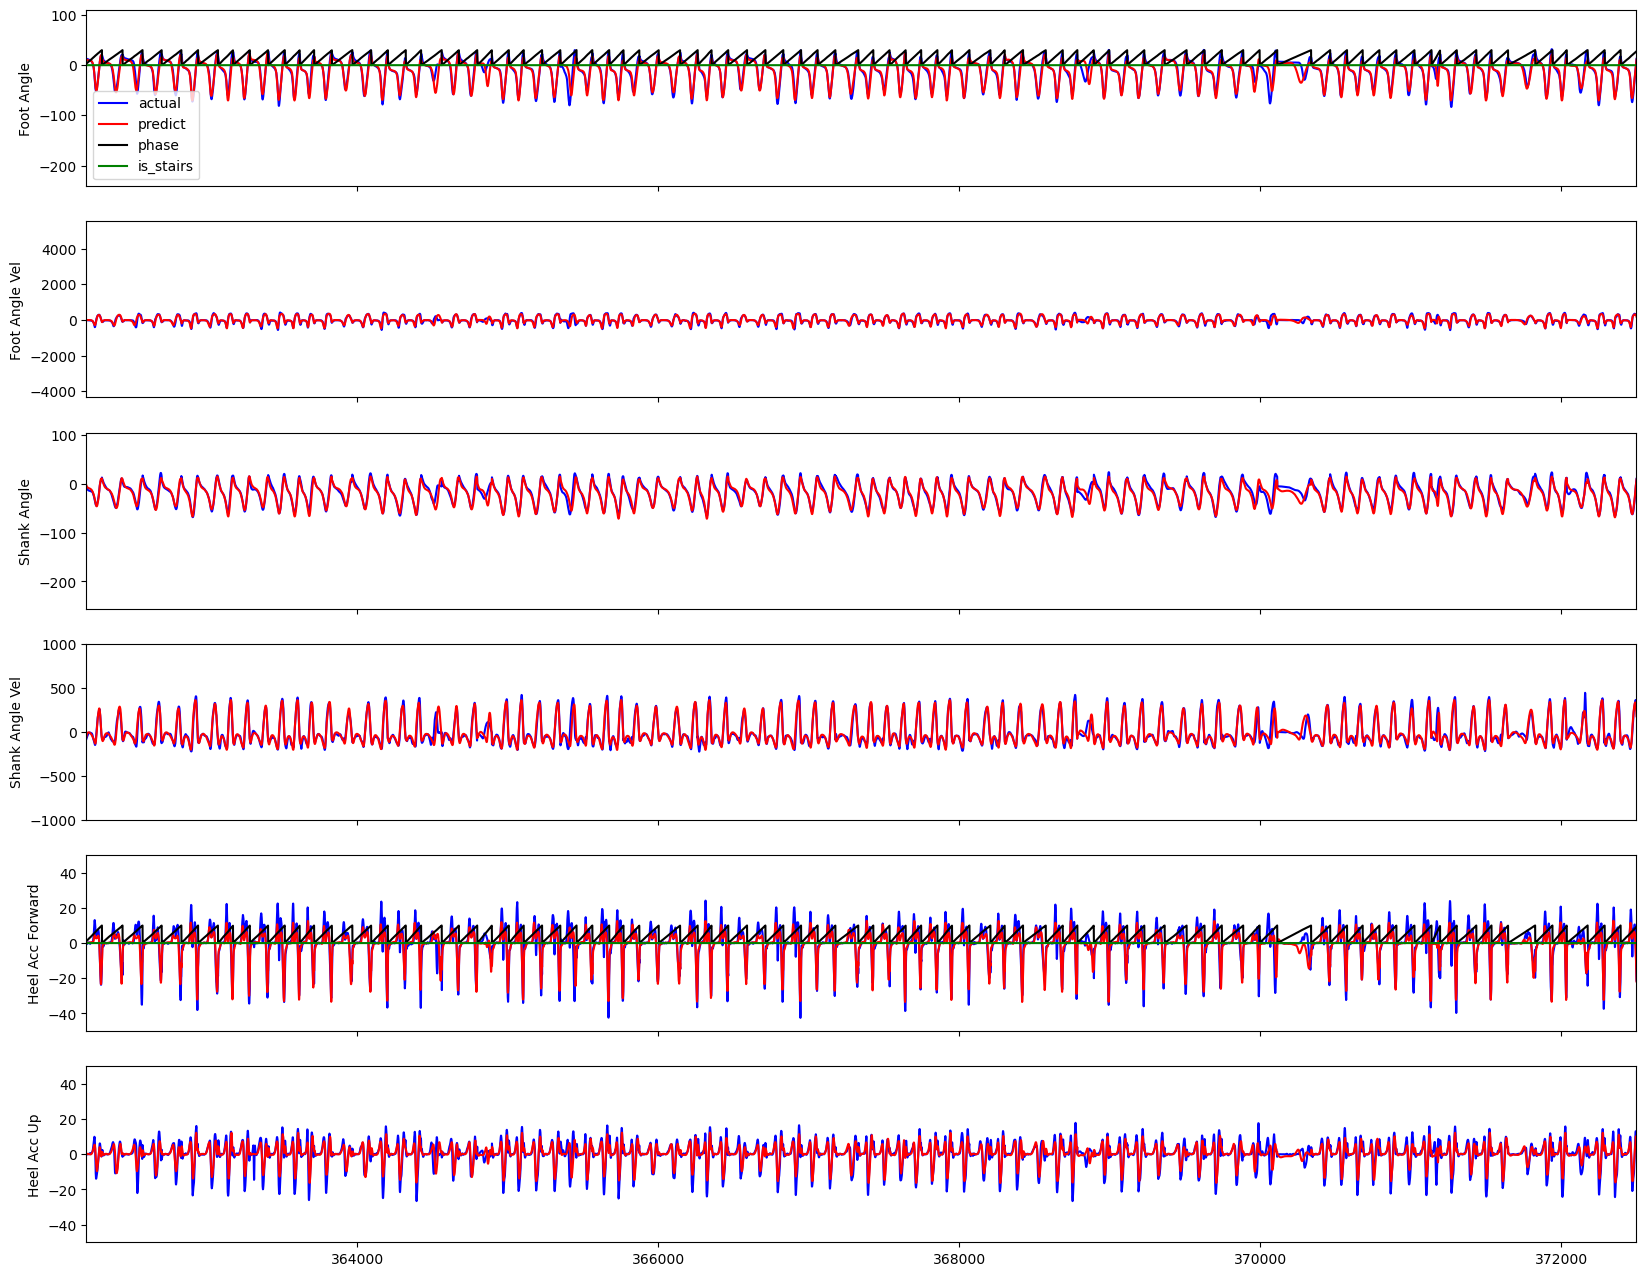

In [14]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)
state_vars = np.array(state_vars)

#bound the accels at +- 100 to filter out the occasional spikes 
predictions[:,4] = np.clip(predictions[:,4],-100,100)
predictions[:,5] = np.clip(predictions[:,5],-100,100)

true_labels[:,4] = np.clip(true_labels[:,4],-100,100)
true_labels[:,5] = np.clip(true_labels[:,5],-100,100)



print(predictions.shape)
print(true_labels.shape)

foot_angle_losses = np.sqrt((predictions[:,0] - true_labels[:,0])**2)
foot_angle_vel_losses = np.sqrt((predictions[:,1] - true_labels[:,1])**2)
shank_angle_losses = np.sqrt((predictions[:,2] - true_labels[:,2])**2)
shank_angle_vel_losses = np.sqrt((predictions[:,3] - true_labels[:,3])**2)
heel_acc_forward_losses = np.sqrt((predictions[:,4] - true_labels[:,4])**2)
heel_acc_up_losses = np.sqrt((predictions[:,5] - true_labels[:,5])**2)


print("="*30)
print(f'Foot Angle Losses: {np.mean(foot_angle_losses):.3f} +- {np.std(foot_angle_losses):.3f}')
print(f'Foot Angle Vel Losses: {np.mean(foot_angle_vel_losses):.3f} +- {np.std(foot_angle_vel_losses):.3f}')
print(f'Shank Angle Losses: {np.mean(shank_angle_losses):.3f} +- {np.std(shank_angle_losses):.3f}')
print(f'Shank Angle Vel Losses: {np.mean(shank_angle_vel_losses):.3f} +- {np.std(shank_angle_vel_losses):.3f}')
print(f'Heel Acc Forward Losses: {np.mean(heel_acc_forward_losses):.3f} +- {np.std(heel_acc_forward_losses):.3f}')
print(f'Heel Acc Up Losses: {np.mean(heel_acc_up_losses):.3f} +- {np.std(heel_acc_up_losses):.3f}')



fig, axs = plt.subplots(6,1,figsize=(20,16),sharex=True)
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].plot(predictions[:,0],'r',label='predict')
axs[0].plot(state_vars[:,0]*30,'k',label='phase')
axs[0].plot(state_vars[:,3]*50,'g',label='is_stairs')

axs[0].legend()
# axs[0].set_xlim([9000,20000])
axs[0].set_xlim([0.3622e6,0.3725e6]) #r01 randomized mix of stairs and inclines
# axs[0].set_xlim([2e6,2.0025e6]) #dataport mix of ramps
# axs[0].set_xlim([3.504e6,3.508e6]) #ordered gt

# axs[0].set_xlim([0.51575e6,0.516e6])

axs[0].set_ylabel('Foot Angle')

axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].plot(predictions[:,1],'r',label='predict')
axs[1].set_ylabel('Foot Angle Vel')
axs[3].set_ylim([-500,600])

axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].plot(predictions[:,2],'r',label='predict')
axs[2].set_ylabel('Shank Angle')

axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].plot(predictions[:,3],'r',label='predict')
axs[3].set_ylabel('Shank Angle Vel')
axs[3].set_ylim([-1000,1000])

axs[4].plot(true_labels[:,4],'b',label='actual')
axs[4].plot(predictions[:,4],'r',label='predict')
axs[4].plot(state_vars[:,0]*10,'k',label='phase')
axs[4].plot(state_vars[:,3]*30,'g',label='is_stairs')

axs[4].set_ylabel('Heel Acc Forward')
axs[4].set_ylim([-50,50])

axs[5].plot(true_labels[:,5],'b',label='actual')
axs[5].plot(predictions[:,5],'r',label='predict')
axs[5].set_ylabel('Heel Acc Up')
axs[5].set_ylim([-50,50])
plt.show()


Using GPU.
Lowest Loss: 0.010548620141964282


Text(0.5, 0, 'Heel Acc Up Stairs (deg)')

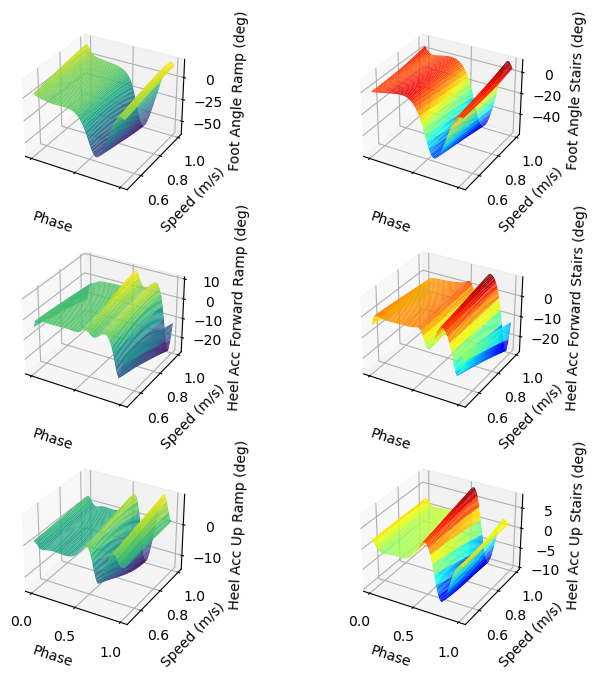

In [15]:
# SET UP KINEMATICS MODEL
dim_val = 64 # 
n_hidden_layers=4
input_size = 5 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 6 # The number of output variables. 

best_model = GaitModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)


if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
best_model.to(device)


model_nickname = 'gait-model-three-stairs'
REMOVE_SUBS_XVAL = True
model_dir = f'../staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'../staging_area/{model_nickname}/model_save_xval/'

checkpoint = torch.load(model_dir+'best_gait_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_model.load_state_dict(g)

epoch = checkpoint['epoch']

# Put model in evaluation mode
best_model.eval()


#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)

speed_vec = np.linspace(0.5,1.0)
phase_vec = np.linspace(0,1)
speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-1,1)
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

xv, yv = np.meshgrid(phase_vec, speed_vec, sparse=False, indexing='ij')

foot_angles_ramp = np.zeros((xv.shape))
foot_angles_stairs = np.zeros((xv.shape))

heel_acc_forward_ramp = np.zeros((xv.shape))
heel_acc_forward_stairs = np.zeros((xv.shape))

heel_acc_up_ramp = np.zeros((xv.shape))
heel_acc_up_stairs = np.zeros((xv.shape))



for i in range(len(phase_vec)):
    for j in range(len(speed_vec)):
        b_state_ramp = np.array([[phase_vec[i],speed_vec[j],0,0]])
        b_state_stairs = np.array([[phase_vec[i],speed_vec[j],0,1]])
        
        b_state_ramp = scale_gait_state(b_state_ramp, speed_scale, incline_scale, stair_height_scale)
        b_state_stairs = scale_gait_state(b_state_stairs, speed_scale, incline_scale, stair_height_scale)
        
        b_state_ramp = torch.from_numpy(b_state_ramp).float().to(device)
        b_state_stairs = torch.from_numpy(b_state_stairs).float().to(device)
        
        b_state_ramp = torch.unsqueeze(b_state_ramp,dim=0)
        b_state_stairs = torch.unsqueeze(b_state_stairs,dim=0)
        
        # print(b_state_ramp.shape)
        # print(b_state_ramp.device)
        
        with torch.no_grad():
            # outputs_ramp = best_model(b_state_ramp,tgt=SOS_token)
            # outputs_stairs = best_model(b_state_stairs,tgt=SOS_token)
            outputs_ramp = best_model(b_state_ramp)
            outputs_stairs = best_model(b_state_stairs)

        foot_angles_ramp[i,j] = (outputs_ramp[0,0,0] * (meas_scale[0,1] - meas_scale[0,0])) + meas_scale[0,0]
        foot_angles_stairs[i,j] = (outputs_stairs[0,0,0] * (meas_scale[0,1] - meas_scale[0,0])) + meas_scale[0,0]
        heel_acc_forward_ramp[i,j] = (outputs_ramp[0,0,4] * (meas_scale[4,1] - meas_scale[4,0])) + meas_scale[4,0]
        heel_acc_forward_stairs[i,j] = (outputs_stairs[0,0,4] * (meas_scale[4,1] - meas_scale[4,0])) + meas_scale[4,0]
        heel_acc_up_ramp[i,j] = (outputs_ramp[0,0,5] * (meas_scale[5,1] - meas_scale[5,0])) + meas_scale[5,0]
        heel_acc_up_stairs[i,j] = (outputs_stairs[0,0,5] * (meas_scale[5,1] - meas_scale[5,0])) + meas_scale[5,0]
        

fig, axs = plt.subplots(3,2,subplot_kw={'projection':'3d'},figsize=(8,8),sharex=True)

axs[0,0].plot_surface(xv, yv, foot_angles_ramp,cmap='viridis')
axs[0,0].set_xlabel('Phase')
axs[0,0].set_ylabel('Speed (m/s)')
axs[0,0].set_zlabel('Foot Angle Ramp (deg)')

# axs[0,1].plot_surface(xv, yv, foot_angles_ramp,cmap='viridis')
axs[0,1].plot_surface(xv, yv, foot_angles_stairs,cmap='jet')
axs[0,1].set_xlabel('Phase')
axs[0,1].set_ylabel('Speed (m/s)')
axs[0,1].set_zlabel('Foot Angle Stairs (deg)')

axs[1,0].plot_surface(xv, yv, heel_acc_forward_ramp,cmap='viridis')
axs[1,0].set_xlabel('Phase')
axs[1,0].set_ylabel('Speed (m/s)')
axs[1,0].set_zlabel('Heel Acc Forward Ramp (deg)')

# axs[1,1].plot_surface(xv, yv, heel_acc_forward_ramp,cmap='viridis')
axs[1,1].plot_surface(xv, yv, heel_acc_forward_stairs,cmap='jet')
axs[1,1].set_xlabel('Phase')
axs[1,1].set_ylabel('Speed (m/s)')
axs[1,1].set_zlabel('Heel Acc Forward Stairs (deg)')

axs[2,0].plot_surface(xv, yv, heel_acc_up_ramp,cmap='viridis')
axs[2,0].set_xlabel('Phase')
axs[2,0].set_ylabel('Speed (m/s)')
axs[2,0].set_zlabel('Heel Acc Up Ramp (deg)')

# axs[1,1].plot_surface(xv, yv, heel_acc_forward_ramp,cmap='viridis')
axs[2,1].plot_surface(xv, yv, heel_acc_up_stairs,cmap='jet')
axs[2,1].set_xlabel('Phase')
axs[2,1].set_ylabel('Speed (m/s)')
axs[2,1].set_zlabel('Heel Acc Up Stairs (deg)')

In [16]:
!gsutil cp -r ../staging_area/gait-model-three-stairs ../full_models/
!zip -r ../full_models/gait-model-three-stairs.zip ../full_models/gait-model-three-stairs/

Copying file://../staging_area/gait-model-three-stairs/model_save_xval/best_gait_model.tar...
Copying file://../staging_area/gait-model-three-stairs/model_save_xval/gait_model_full.pt...
Copying file://../staging_area/gait-model-three-stairs/model_save_xval/gait_model_params.pt...
Copying file://../staging_area/gait-model-three-stairs/model_save_xval/checkpoints/gait_model_checkpoint_2.tar...
/ [4 files][579.6 KiB/579.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://../staging_area/gait-model-three-stairs/model_save_xval/checkpoints/gait_model_checkpoint_9.tar...
Copying file://../staging_area/gait-model-three-stairs/model_save_xval/checkpoints/gait_model_checkpoint_5.tar...
Copying file://../staging_area/gait-model-t

In [17]:
!gsutil cp -r ../full_models/gait-model-three-stairs/ gs://ml_gait_estimation/full_models/
!gsutil cp ../full_models/gait-model-three-stairs.zip gs://ml_gait_estimation/full_models/


Copying file://../full_models/gait-model-three-stairs/model_save_xval/best_gait_model.tar [Content-Type=application/x-tar]...
Copying file://../full_models/gait-model-three-stairs/model_save_xval/gait_model_full.pt [Content-Type=application/octet-stream]...
Copying file://../full_models/gait-model-three-stairs/model_save_xval/gait_model_params.pt [Content-Type=application/octet-stream]...
Copying file://../full_models/gait-model-three-stairs/model_save_xval/checkpoints/gait_model_checkpoint_2.tar [Content-Type=application/x-tar]...
- [4 files][579.6 KiB/579.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://../full_models/gait-model-three-stairs/model_save_xval/checkpoints/gait_model_checkpoint_9.tar [Content-Type=appli